# Bias, overfitting and regularization

Our machine learning algorithm learns from the training set and can then make predictions for new inputs. However, there's a risk that the algorithm has learned about the training set so well, that it will not generalize to new inputs, and consequently performs poorly. This is a major concern in machine learning that we'll address next. 

Please watch the following videos (~20 min.):
- [Regularization: the problem of overfitting](https://www.youtube.com/watch?v=OSd30QGMl88) (9 min.). Concepts to grasp:
    * Overfitting (high variance), underfitting (high bias). 
    * Too many features (different features from the domain or constructed features like polynomials) -> risk of overfitting!! Prevention: reduce number of features by only selecting the features that really matter. This can be done manually, or automatically. Automatic methods: correlation (heat map), dimensionality reduction (PCA), .... More info [here](https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de). Of course, by ignoring features, important information might be lost!
    * Too few training samples -> risk for overfitting!! Counter measures: artificially increase the number of training samples.
    * With many features, plotting the data is not possible any more to see if overfitting occurs.
    * Careful model selection to prevent overfitting.
- [Regularization: cost function](https://www.youtube.com/watch?v=3NXspPcl3u4) (10 min.). Concepts to grasp: regularization. Regularization parameter lambda is a trade-off between fitting the training set wel and prevent overfitting. On other words lambda is a trade-off between bias and high variance. By convention, theta_0 is not regularized. 

# Case description
You will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on microchips fabricated in the past, from which you can build a logistic regression model.

**Exercise**:
* read the training data. Feature 1 (column 0) is the result of test 1. Feature 2 (column 1) is the result of test 2. The third column is the label and determines whether the microchip was accepted or rejected.
* save the data in ```X``` and ```y```.
* explore the training data using ```df.head()```.
* visualize the training data. x-axis: Microchip Test1, y-axis: Microchip Test2', use a mask to give passed and rejected microchips a different colour.

The plot should look similar to:
<img src="dataVisualization2.png" />

The figure shows that our dataset cannot be separated into positive and negative examples by a straight line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset, as logistic regression will only be able to find a linear decision boundary.

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# read the training data
# your code
df = pd.read_csv('ex2data2.txt', header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [272]:
# explore the data
# your code
df.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


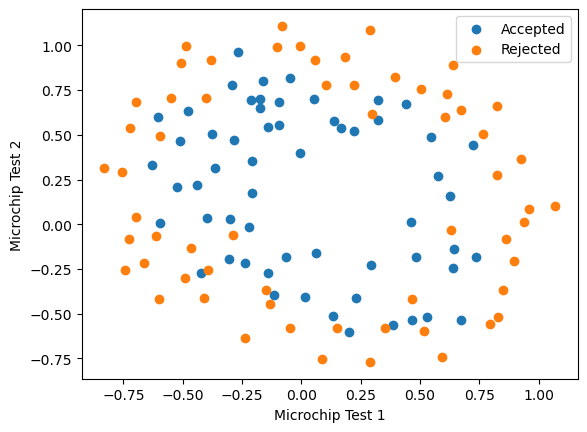

In [273]:
# visualize the data
# your code
mask = y == 1
passed = plt.scatter(X[mask][0], X[mask][1])
failed = plt.scatter(X[~mask][0], X[~mask][1])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend((passed, failed), ('Accepted', 'Rejected'))
plt.show()

In [274]:
# prepare the training set
# your code
y = y.to_numpy()[:, np.newaxis]

## Feature mapping
One way to fit the data better is to create more features from each data point. Hence we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

![feature mapping](./featureMapping.png)

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

We'll do feature mapping for polynomials up to degree 6. This can easily be done by using [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). 

In [275]:
# feature mapping
degree = 6

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree, include_bias=True)  # with include_bias=True PolynomialFeatures includes x_0 for us
X = poly_reg.fit_transform(X)
(m, n) = X.shape

In [276]:
# sigmoid and hypothesis functions are copied from the previous hands-on, as they are not different for regularized logistic regression

# by convention, call the function parameter z
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# hypothesis
def h(X, theta):
    return sigmoid(X @ theta)  # alternative way of writing dot product

The cost function for logistic regression (previous hands-on) has been extended by a regularization term to avoid overfitting. By convention $\Theta_0$ is not used in the regularization term:
![Regularized logistic regression cost function](./logisticRegressionCostFunctionRegularized.png)

This is called L2 regularization, because the regularization term squares the thetas.

**Exercise**: implement the body of the regularized cost function.

In [277]:
# regularized cost function
def Jreg(X, y, theta, lambdaa):
    m = len(y)
    h_val = h(X, theta)
    return 1/m * np.sum(-y.T @ np.log(h_val) - (1-y).T @ np.log(1-h_val)) + lambdaa/(2*m) * np.sum(theta[1:]**2)

The gradient for logistic regression (previous hands-on) has been extended by a regularization term to avoid overfitting. By convention $\Theta_0$ is not used in the regularization term:

![Regularized gradient](./gradientRegularized.png)

**Exercise**: implement the body of the regularized gradient.

In [278]:
# gradient
def gradReg(X, y, theta, lambdaa):
    grad = (1/m) * X.T @ (h(X, theta) - y)  # simultaneous update
    grad[1:] = grad[1:] + (lambdaa / m) * theta[1:]
    return grad

In [279]:
# freehand test of cost function and gradient
theta = np.zeros((n, 1))
lambdaa = 0  # lambda is a python keyword, therefore an additional a in the name
print(Jreg(X, y, theta, lambdaa))  # should be 0.6931471805599453
np.testing.assert_array_almost_equal_nulp(Jreg(X, y, theta, lambdaa), 0.6931471805599453)

# there are 28 values to verify, but we only test the first 3 out of laziness
np.testing.assert_array_almost_equal_nulp(gradReg(X, y, theta, lambdaa)[0], [0.00847457627118644238])
np.testing.assert_array_almost_equal_nulp(gradReg(X, y, theta, lambdaa)[1], [0.01878809322033896806])
np.testing.assert_array_almost_equal_nulp(gradReg(X, y, theta, lambdaa)[2], [0.00007777118644069724])

0.6931471805599453


In [280]:
# learning algorithm for logsitic regression (identical to the one in the hands-on about linear regression!)
def gradientDescent(X, y, theta, lambdaa, alpha, num_iters):
    J_history = []
    for _ in range(num_iters):
        theta -= alpha * gradReg(X, y, theta, lambdaa)
        J_history.append(Jreg(X, y, theta, lambdaa))  # to allow displaying cost as a function of #iters
    return theta, J_history

In [281]:
# perform learning, but use a more sophisticated optimizer than gradient descent: fmin_tn
# define as function to allow reuse
def learn(X, y, theta, lambdaa):
    import scipy.optimize as opt

    def Jreg_(theta, X, y, lamdaa):
        return Jreg(X, y, theta, lamdaa)
    def gradReg_(theta, X, y, lamdaa):
        return gradReg(X, y, theta, lamdaa)

    output = opt.fmin_tnc(func = Jreg_, x0 = theta.flatten(), fprime = gradReg_, args = (X, y.flatten(), lambdaa))
    theta = output[0][:, np.newaxis]  # transform theta from vector to matrix
    print(theta[0:5]) # only the first 5; should be [ 1.27271026  0.62529965  1.18111686 -2.01987398 -0.91743189]
    return theta

lambdaa = 1
theta = learn(X, y, theta, lambdaa)

[[ 1.27271026]
 [ 0.62529964]
 [ 1.18111686]
 [-2.01987398]
 [-0.91743189]]


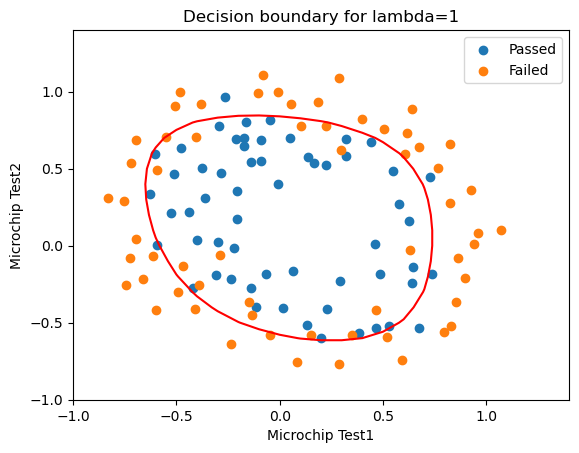

In [282]:
# plot decision boundary (define as function to allow reuse)
def plot_decision_boundary(theta, lambdaa):
    U, V = np.meshgrid(np.arange(-1, 1.5, 0.1), np.arange(-1, 1.5, 0.1))  # shape (25,25)
    poly_reg_bias = PolynomialFeatures(degree, include_bias=True)  # with include_bias=True PolynomialFeatures includes x_0 for us
    poly = poly_reg_bias.fit_transform(np.column_stack((U.flatten(), V.flatten())))  # shape (625,2) -> shape (625,6)
    Z = np.dot(poly, theta)  # perform the prediction
    Z = Z.reshape((25,25))
    plt.contour(U, V, Z, 0, colors='red')
    
    mask = y == 1
    X_ = df.iloc[:,:-1]  # original X
    passed = plt.scatter(X_[mask][0], X_[mask][1])
    failed = plt.scatter(X_[~mask][0], X_[~mask][1])
    plt.xlabel('Microchip Test1')
    plt.ylabel('Microchip Test2')
    plt.legend((passed, failed), ('Passed', 'Failed'))
    plt.title('Decision boundary for lambda=' + str(lambdaa))
    plt.show()

plot_decision_boundary(theta, lambdaa)

In [283]:
# accuracy (same source code as previous hands-on)
def accuracy(X, y, theta):
    pred = h(X, theta) >= 0.5
    acc = np.mean(np.array(pred) == y)
    return acc * 100

print("accuracy = " + str(accuracy(X, y, theta)))  # should be 83.05%

accuracy = 83.05084745762711


Let's try different lambdaa's to see the effects of overfitting and underfitting. Plot the decision boundary and calculate the accuracy. Are the results according to your expectation?

**Discussion**: With $\lambda = 0$, we see that indeed the decision boundary is less smooth, which is some indication of overfitting, as the decision boundary is optimized for the training set and will generalize less well for other data. Later in this course, we'll introduce the so-called validation set, which is labeled data that the model is not trained for. When the model does very well for the training set, but not well for the validation set, this is a clear sign of overfitting.

**Exercise**: adding more features, will allow the model to better fit the training set, so there's more risk of overfitting. Try this by setting degree=8 (and put the two tests in comments, as they will fail). This will generate more polynomials, so more features. This will show clearer that model is overfitting. Also note the higher accuracy.

[[  10.44317873]
 [  12.77589785]
 [   4.17321046]
 [-102.91173246]
 [ -47.56025773]]


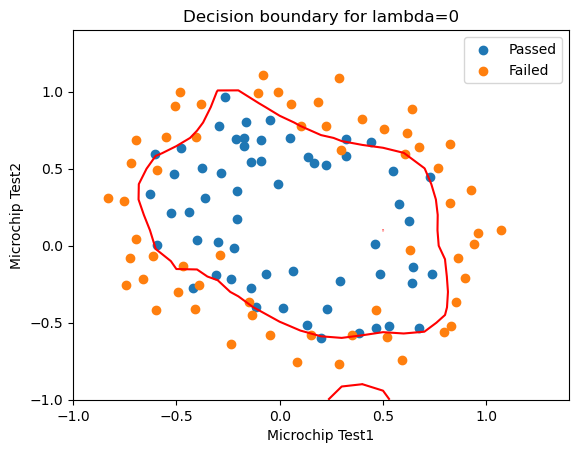

accuracy = 86.4406779661017
[[ 1.27271026]
 [ 0.62529964]
 [ 1.18111686]
 [-2.01987398]
 [-0.91743189]]


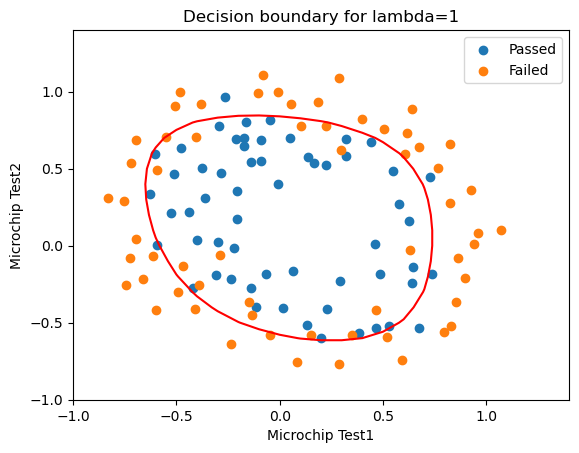

accuracy = 83.05084745762711
[[ 0.02187847]
 [-0.0174817 ]
 [ 0.00571065]
 [-0.05516901]
 [-0.01314874]]


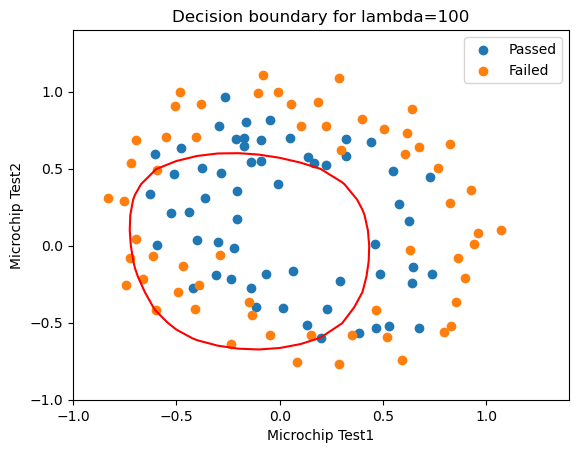

accuracy = 61.016949152542374
[[ 0.00427733]
 [-0.01251219]
 [ 0.00302452]
 [-0.03715894]
 [-0.00890139]]


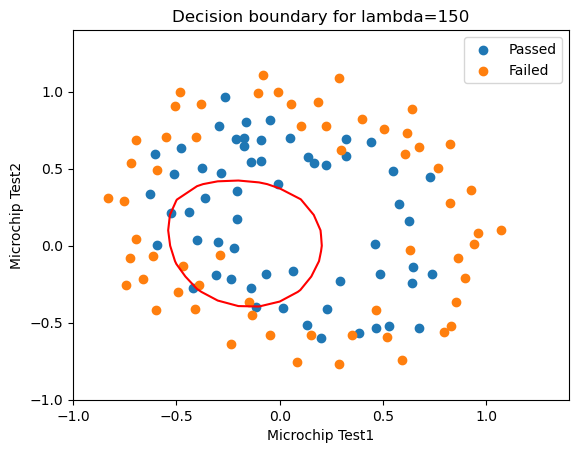

accuracy = 58.47457627118644


In [284]:
lambdaas = [0, 1, 100, 150]
for lambdaa in lambdaas:
    theta = np.zeros((n, 1))
    
    # own gradient descent implementation
    num_iters = 150000 # hyper parameter number of iterations
    alpha = 0.002  # hyper parameter learning rate
    #theta, J_history = gradientDescent(X, y, theta, lambdaa, alpha, num_iters)

    # optimized learning algorithm
    theta = learn(X, y, theta, lambdaa)

    plot_decision_boundary(theta, lambdaa)
    print("accuracy = " + str(accuracy(X, y, theta)))

Please don’t look at it yet, but the Jupyter notebook with the solution is also available, in case you run into problems.